In [8]:
!pip install pyarrow

!pip uninstall scikit-learn -y

!pip install -U scikit-learn==1.5

!pip install category_encoders==2.7

Found existing installation: scikit-learn 1.5.0
Uninstalling scikit-learn-1.5.0:
  Successfully uninstalled scikit-learn-1.5.0
  Using cached scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.4 MB/s eta 0:00:00


Dataset Overview and Cleaning

In [9]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load
from tensorflow.keras.callbacks import ModelCheckpoint
import category_encoders as ce
from sklearn.model_selection import KFold, GridSearchCV

## HELPER FUNCS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def analyze_borough_trips(df):
    # Create pivot tables for average fare and distance
    avg_fare_pivot = pd.pivot_table(
        df,
        values='fare_amount',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )

    avg_distance_pivot = pd.pivot_table(
        df,
        values='trip_distance',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot heatmap for fares
    sns.heatmap(avg_fare_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('Average Fare Amount by Borough Routes')

    # Plot heatmap for distances
    sns.heatmap(avg_distance_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Average Trip Distance by Borough Routes')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary of trips between boroughs:")
    borough_counts = df.groupby(['Borough_pu', 'Borough_do']).size().reset_index()
    borough_counts.columns = ['Pickup Borough', 'Dropoff Borough', 'Number of Trips']
    print(borough_counts.sort_values('Number of Trips', ascending=False))

# 2. Box plots for fare distribution by borough pairs
def plot_fare_distributions(df):
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='Borough_pu', y='fare_amount', hue='Borough_do', data=df)
    plt.title('Fare Distribution by Borough Routes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Scatter plot of distance vs fare, colored by borough pairs
def plot_distance_vs_fare(df):
    plt.figure(figsize=(12, 8))
    for (pu, do), group in df.groupby(['Borough_pu', 'Borough_do']):
        plt.scatter(group['trip_distance'], group['fare_amount'],
                   label=f'{pu} to {do}', alpha=0.6)

    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Fare Amount ($)')
    plt.title('Trip Distance vs Fare Amount by Borough Routes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## DATA PULLS

In [10]:
from google.colab import drive
drive.mount('/content/drive')
# processed_data_path = "/content/drive/MyDrive/yellow_processed_05.parquet"
processed_data_path = "/content/drive/MyDrive/yellow_processed_02.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the updated DataLoader class
sys.path.append(str(Path("../src").resolve()))
from data.data_loader import DataLoader

# Define file paths
data_path = "../data/raw/yellow_tripdata_2022-05.parquet"
output_path = "../data/processed/cleaned_yellow_tripdata_2022-05.parquet"

# Initialize the DataLoader
loader = DataLoader(data_path, output_path)

# Preprocess the data (this step generates the cleaned data file)
loader.preprocess()

In [ ]:

# Load the preprocessed data
processed_data_path = "yellow_processed_05.v2.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

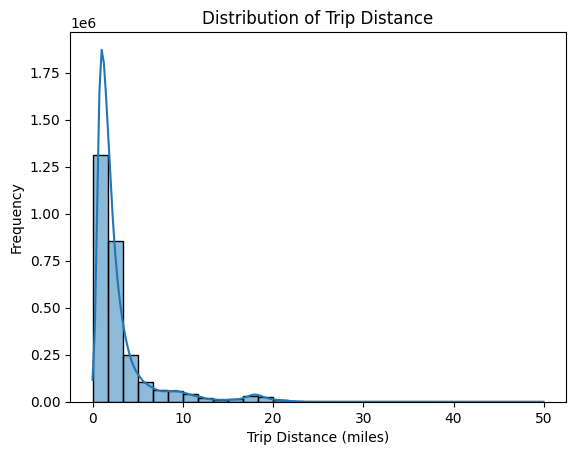

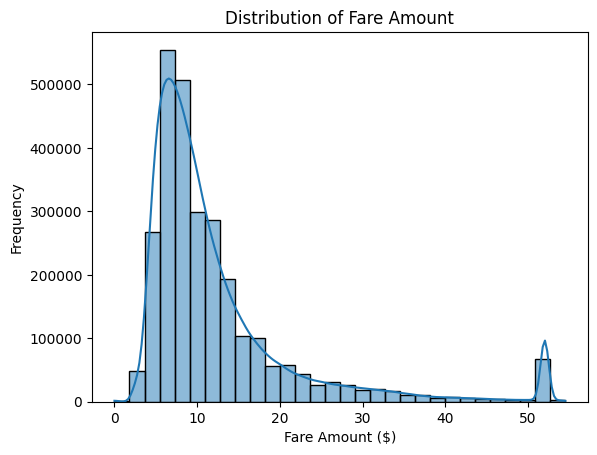

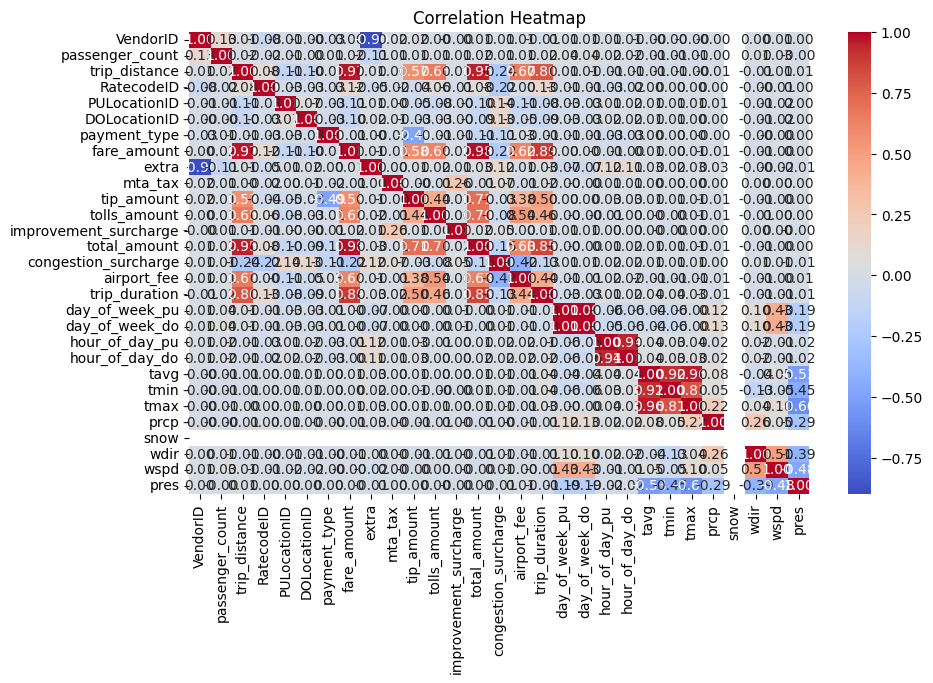

In [11]:
# Visualize the data
# Distribution of trip distance
sns.histplot(cleaned_df['trip_distance'], kde=True, bins=30)
plt.title("Distribution of Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

# Distribution of fare amount
if 'fare_amount' in cleaned_df.columns:
    sns.histplot(cleaned_df['fare_amount'], kde=True, bins=30)
    plt.title("Distribution of Fare Amount")
    plt.xlabel("Fare Amount ($)")
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap
numeric_df = cleaned_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



In [ ]:
cleaned_df['fare_amount'].describe()

,fare_amount
count,1.036978e+07
mean,1.789875e+01
std,1.510588e+01
min,1.000000e-02
25%,8.600000e+00
50%,1.280000e+01
75%,2.050000e+01
max,6.500000e+02


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

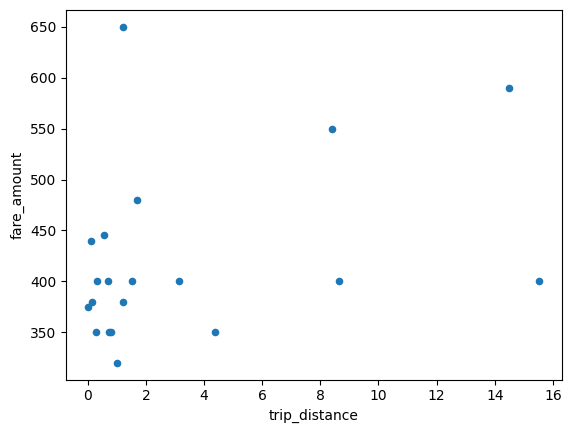

In [ ]:
three_std_deviations = 1.465398e+01 + 3 * 9.641945e+01
mask_above_three_std_deviations = cleaned_df['fare_amount'] > three_std_deviations
below_crazy_fare_amount = cleaned_df['fare_amount'] < 50000

cleaned_df[mask_above_three_std_deviations & below_crazy_fare_amount].plot.scatter(x='trip_distance', y='fare_amount')

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

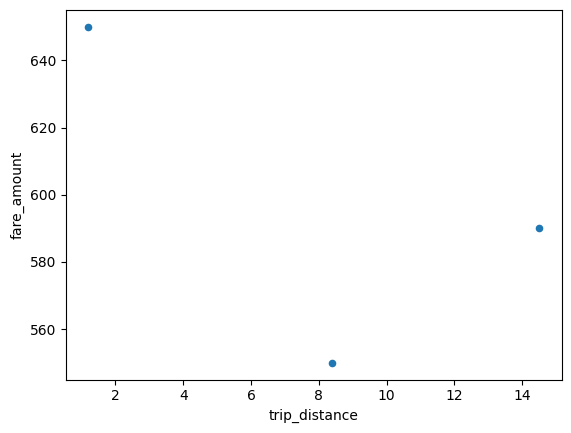

In [ ]:
mask_fares_below_7000 = cleaned_df['fare_amount'] < 6000
mask_fares_above_6000 = cleaned_df['fare_amount'] > 500
mask_initiated_outside_nyc = cleaned_df['PULocationID'] == 265
mask_dropped_outside_nyc = cleaned_df['DOLocationID'] == 265
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000].plot.scatter(x='trip_distance', y='fare_amount')


In [ ]:
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000][['Borough_pu', 'Borough_do', 'DOLocationID', 'trip_distance', 'fare_amount']].head()

,Borough_pu,Borough_do,DOLocationID,trip_distance,fare_amount
2231078,Manhattan,Manhattan,162,1.2,650.00
4966954,Manhattan,Queens,129,8.4,550.00
5808103,Queens,Queens,7,14.5,590.01


In [ ]:
cleaned_df.size - cleaned_df[cleaned_df['PULocationID'] == 265].size


342202707

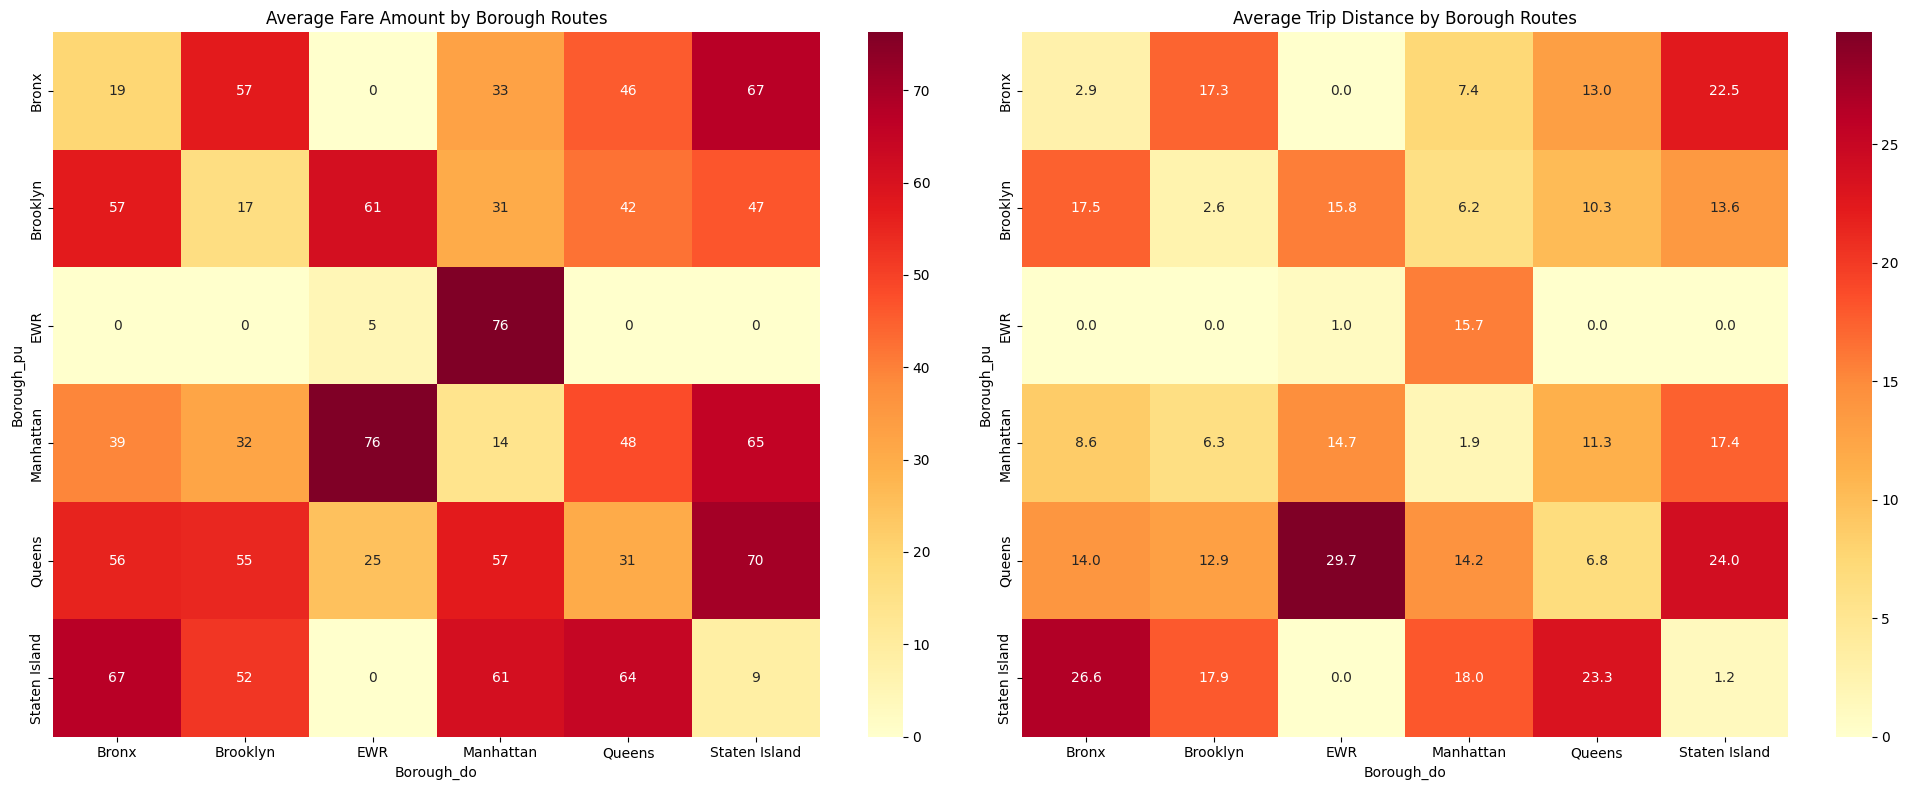


Summary of trips between boroughs:
   Pickup Borough Dropoff Borough  Number of Trips
16      Manhattan       Manhattan          2583411
22         Queens       Manhattan           184358
17      Manhattan          Queens            96572
23         Queens          Queens            69638
14      Manhattan        Brooklyn            65023
20         Queens        Brooklyn            45633
13      Manhattan           Bronx             8380
6        Brooklyn        Brooklyn             8356
8        Brooklyn       Manhattan             5500
19         Queens           Bronx             5396
0           Bronx           Bronx             2058
9        Brooklyn          Queens             1379
2           Bronx       Manhattan             1131
15      Manhattan             EWR              743
1           Bronx        Brooklyn              288
3           Bronx          Queens              267
5        Brooklyn           Bronx              257
18      Manhattan   Staten Island             

In [8]:
filtered_df = cleaned_df#[mask_fares_above_6000 & mask_fares_below_7000]
analyze_borough_trips(filtered_df)

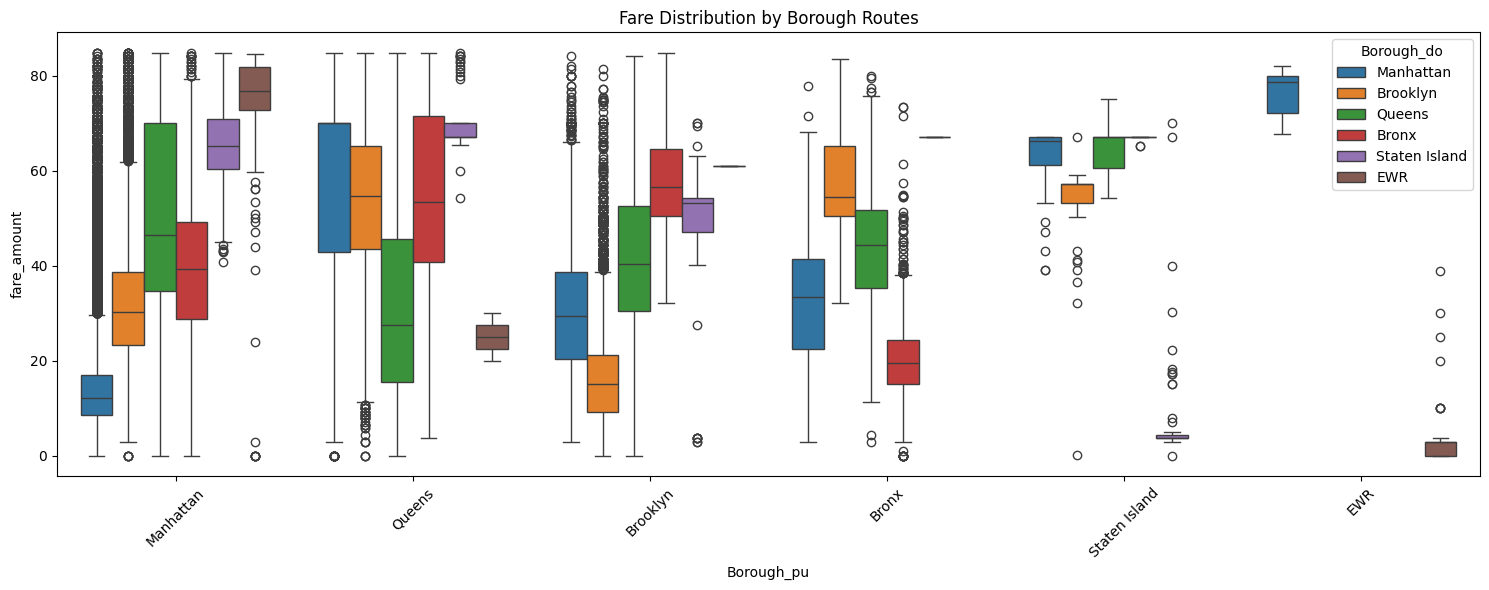

In [9]:
plot_fare_distributions(filtered_df)

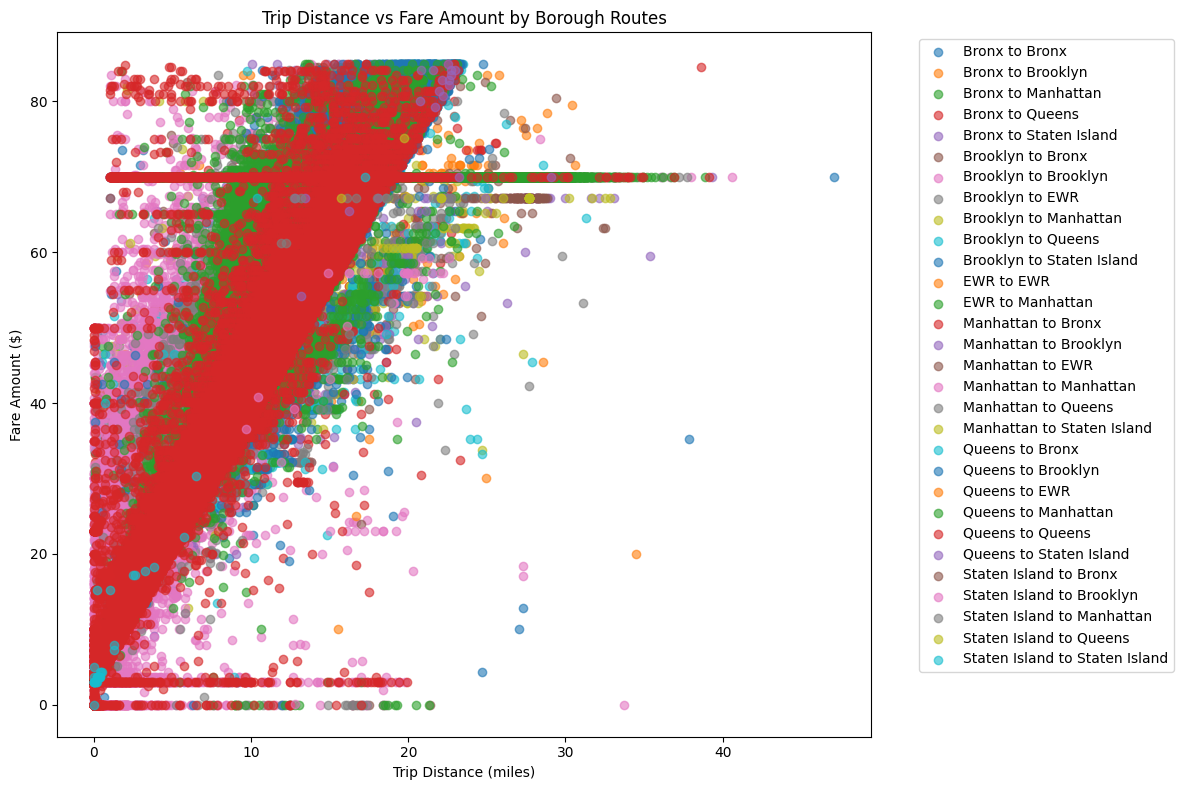

In [10]:
plot_distance_vs_fare(filtered_df)

In [16]:
short_trips = cleaned_df[cleaned_df['trip_distance'] <= 0.01]
short_trips_not_in_same_zone = short_trips[short_trips['PULocationID'] != short_trips['DOLocationID']]
short_trips_not_same_borough = short_trips_not_in_same_zone[short_trips_not_in_same_zone['Borough_do'] != short_trips_not_in_same_zone['Borough_pu']]

short_trips_not_in_same_zone[['Zone_pu', 'Zone_do']].value_counts()

Zone_pu                  Zone_do                
Astoria                  Queensbridge/Ravenswood    51
East Elmhurst            LaGuardia Airport          45
Upper East Side South    Upper East Side North      43
Upper East Side North    Upper East Side South      30
Queensbridge/Ravenswood  Astoria                    30
                                                    ..
Lenox Hill East          Murray Hill                 1
                         Roosevelt Island            1
Lenox Hill West          Central Harlem North        1
                         Central Park                1
Lower East Side          Union Sq                    1
Name: count, Length: 897, dtype: int64

In [12]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration',
       'Borough_pu', 'Zone_pu', 'service_zone_pu', 'Borough_do', 'Zone_do',
       'service_zone_do', 'day_of_week_pu', 'day_of_week_do', 'hour_of_day_pu',
       'hour_of_day_do', 'time_of_day_pu', 'time_of_day_do', 'tavg', 'tmin',
       'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'],
      dtype='object')

In [ ]:
cleaned_df['Borough_do_zone'].value_counts()

Borough_do_zone
Manhattan        34672346
Queens            2109647
Brooklyn          1524470
Bronx              233924
Unknown            228124
EWR                106257
Staten Island        9666
Name: count, dtype: int64

# TRAIN THE MODEL

# MODELS

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Linear Regression model

In [39]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration',
       'Borough_pu', 'Zone_pu', 'service_zone_pu', 'Borough_do', 'Zone_do',
       'service_zone_do', 'day_of_week_pu', 'day_of_week_do', 'hour_of_day_pu',
       'hour_of_day_do', 'time_of_day_pu', 'time_of_day_do', 'tavg', 'tmin',
       'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres'],
      dtype='object')

In [83]:
target = 'trip_duration'
# target = 'fare_amount'
features = ['trip_distance', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'hour_of_day_pu', 'time_of_day_pu',
        'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']

In [84]:
cleaned_df[features].describe()

,trip_distance,day_of_week_pu,hour_of_day_pu,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
count,3.188194e+06,3.188194e+06,3.188194e+06,3.188194e+06,3.188194e+06,3.188194e+06,3.188194e+06,3188194.0,3.188194e+06,3.188194e+06,3.188194e+06
mean,3.267844e+00,2.990927e+00,1.445166e+01,1.778213e+01,1.426063e+01,2.214431e+01,2.445954e+00,0.0,1.549476e+02,8.307412e+00,1.013494e+03
std,4.141369e+00,1.828346e+00,5.656334e+00,3.907974e+00,3.529474e+00,4.551225e+00,4.740676e+00,0.0,1.119179e+02,2.315236e+00,5.125643e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.070000e+01,8.300000e+00,1.220000e+01,0.000000e+00,0.0,2.000000e+01,4.700000e+00,1.002400e+03
25%,1.020000e+00,2.000000e+00,1.100000e+01,1.580000e+01,1.170000e+01,1.800000e+01,0.000000e+00,0.0,5.400000e+01,6.500000e+00,1.010200e+03
50%,1.720000e+00,3.000000e+00,1.500000e+01,1.770000e+01,1.440000e+01,2.300000e+01,3.000000e-01,0.0,1.140000e+02,7.900000e+00,1.013600e+03
75%,3.220000e+00,4.000000e+00,1.900000e+01,2.080000e+01,1.600000e+01,2.610000e+01,2.800000e+00,0.0,2.570000e+02,1.010000e+01,1.015600e+03
max,4.690000e+01,6.000000e+00,2.300000e+01,2.460000e+01,2.060000e+01,2.830000e+01,2.630000e+01,0.0,3.550000e+02,1.520000e+01,1.026100e+03


In [90]:
X = cleaned_df[features]
y = cleaned_df[target]

In [91]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Preprocessing pipeline
categorical_features = ['Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'time_of_day_pu']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu',
                      'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']

In [93]:
# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [95]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [96]:
dump(preprocessor, 'linear_reg_preprocessor.joblib')

['linear_reg_preprocessor.joblib']

In [97]:
y_train = y_train.values
y_test = y_test.values

In [98]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [99]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['mae'])

In [101]:
checkpoint_cb = ModelCheckpoint(
    filepath=f'linear_regression_{target}.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [102]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=5000,
                    callbacks=[checkpoint_cb])

Epoch 1/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 314.4205 - mae: 11.8906
Epoch 1: val_loss improved from inf to 115.26145, saving model to linear_regression_trip_duration.keras
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 314.1805 - mae: 11.8845 - val_loss: 115.2615 - val_mae: 7.1487
Epoch 2/30
400/409 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.6480 - mae: 6.8173
Epoch 2: val_loss improved from 115.26145 to 80.35765, saving model to linear_regression_trip_duration.keras
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 102.4250 - mae: 6.8106 - val_loss: 80.3577 - val_mae: 6.1078
Epoch 3/30
404/409 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 77.0677 - mae: 6.0121
Epoch 3: val_loss improved from 80.35765 to 70.67857, saving model to linear_regression_trip_duration.keras
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 77.0344 - mae: 6.0109 - val_loss: 70.6786 - val_mae: 5.7715
Epoch 4/30
402/409 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69.0311 - mae: 5.7205
Epoch 4: val_loss

In [ ]:
# load model if saved
from tensorflow.keras.models import load_model
model = load_model(f'/content/linear_regression_{target}.keras')

## Accuracy of Linear Regression model

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Statistics against {target}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R^2:  {r2:.2f}")

19927/19927 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
Statistics against trip_duration
MSE:  55.32
RMSE: 7.44
MAE:  4.96
R^2:  0.73


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Statistics against {target}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R^2:  {r2:.2f}")

19927/19927 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
Statistics against fare_amount
MSE:  18.47
RMSE: 4.30
MAE:  2.78
R^2:  0.92


In [ ]:
def accuracy_within_t(y_true, y_pred, T=5.0):
    errors = np.abs(y_true - y_pred)
    return np.mean(errors <= T)

# Suppose y_test, y_pred are numpy arrays:
tolerance = 2.0
acc = accuracy_within_t(y_test[:,1], y_pred, tolerance)
print(f"Fraction of predictions within ${tolerance}: {acc:.2%}")

# XGBOOST with OneHotEncoder

In [ ]:
categorical_features = ['store_and_fwd_flag', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'time_of_day_pu']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu', ]
all_features = categorical_features + numerical_features
target_col = 'fare_amount'

X = cleaned_df[all_features]
y = cleaned_df[target_col]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [ ]:
cat_transform_name, cat_encoder, cat_cols = preprocessor.transformers_[0]
num_transform_name, num_scaler, num_cols = preprocessor.transformers_[1]

cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

# Combine them with the numeric column names
final_feature_names = np.concatenate([cat_feature_names, num_cols])

print("Final feature name array:\n", final_feature_names)

In [ ]:
X_train_prep.shape

(8295823, 546)

### Main model training

In [ ]:
from xgboost import XGBRegressor

# Create the model
xgb_model = XGBRegressor(
    n_estimators=100,        # number of trees
    max_depth=6,             # maximum depth of each tree
    learning_rate=0.1,       # shrinkage (eta)
    subsample=0.8,           # fraction of data for each tree
    colsample_bytree=0.8,    # fraction of features for each tree
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
)

In [ ]:
xgb_model.fit(
    X_train_prep,
    y_train,
    eval_set=[(X_test_prep, y_test)],  # for early stopping
    verbose=True                  # prints training progress
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:11.69252
[1]	validation_0-rmse:10.84992
[2]	validation_0-rmse:10.11281
[3]	validation_0-rmse:9.47275
[4]	validation_0-rmse:8.91300
[5]	validation_0-rmse:8.42734
[6]	validation_0-rmse:8.11403
[7]	validation_0-rmse:7.85322
[8]	validation_0-rmse:7.63988
[9]	validation_0-rmse:7.45303
[10]	validation_0-rmse:7.16455
[11]	validation_0-rmse:6.92010
[12]	validation_0-rmse:6.70787
[13]	validation_0-rmse:6.52948
[14]	validation_0-rmse:6.37969
[15]	validation_0-rmse:6.24915
[16]	validation_0-rmse:6.14107
[17]	validation_0-rmse:6.05058
[18]	validation_0-rmse:5.96798
[19]	validation_0-rmse:5.92485
[20]	validation_0-rmse:5.86172
[21]	validation_0-rmse:5.82617
[22]	validation_0-rmse:5.77735
[23]	validation_0-rmse:5.73296
[24]	validation_0-rmse:5.69520
[25]	validation_0-rmse:5.66354
[26]	validation_0-rmse:5.63559
[27]	validation_0-rmse:5.60998
[28]	validation_0-rmse:5.58815
[29]	validation_0-rmse:5.57015
[30]	validation_0-rmse:5.55658
[31]	validation_0-rmse:5.53618
[32]	validation

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

In [ ]:
# saving the model
xgb_model.save_model('xgb_model.json')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
y_pred = xgb_model.predict(X_test_prep)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:04:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


MAE:  3.499
MSE:  27.179
RMSE: 5.213
R^2:  0.828


### hyperparameter tunning

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.1, 0.01],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

In [ ]:
# Define XGBoost model for regression, using GPU
xgb_reg = xgb.XGBRegressor(
    tree_method='gpu_hist',   # Use GPU-accelerated tree building
    predictor='gpu_predictor',
    random_state=42
)

xgb_model_cpu = xgb.XGBRegressor(tree_method='hist', predictor='cpu_predictor')

In [ ]:


# Combine into a scikit-learn Pipeline:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb_model_cpu)
])

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_mean_squared_error', 'r2', etc.
    verbose=2,       # Controls the amount of logging
    n_jobs=-1        # Use all CPU cores for parallelism
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:47:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['store_and_fwd_flag',
                                                                          'Borough_pu',
                                                                          'Zone_pu',
                                                                          'service_zone_pu',
                                                                          'Borough_do',
                                                                          'Zone_do',
                                                                          'service_zone_do',
                                                                          'time_of_day_pu']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['trip_distance',
                                                                          'day_of_week_pu',
                                                                          'hour_of_day_pu'])])),
                                       ('xgb',
                                        XG...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor='cpu_predictor', ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__learning_rate': [0.1, 0.01],
                         'xgb__max_depth': [4, 6],
                         'xgb__n_estimators': [100, 300],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print("Best Score:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.predict(X_test)

Best Score: -3.09758033773894
Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 300, 'xgb__subsample': 1.0}


array([14.600942, 23.180311,  5.22742 , ..., 10.630331, 49.29061 ,
        9.414047], dtype=float32)

In [ ]:
best_model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['store_and_fwd_flag', 'Borough_pu', 'Zone_pu',
                                   'service_zone_pu', 'Borough_do', 'Zone_do',
                                   'service_zone_do', 'time_of_day_pu']),
                                 ('num', StandardScaler(),
                                  ['trip_distance', 'day_of_week_pu',
                                   'hour_of_day_pu'])]),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot

In [ ]:
best_model.named_steps['xgb'].save_model('gridsearch_xgb_fare.json')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:49:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

MAE:  3.364
RMSE: 5.024
R²:   0.841


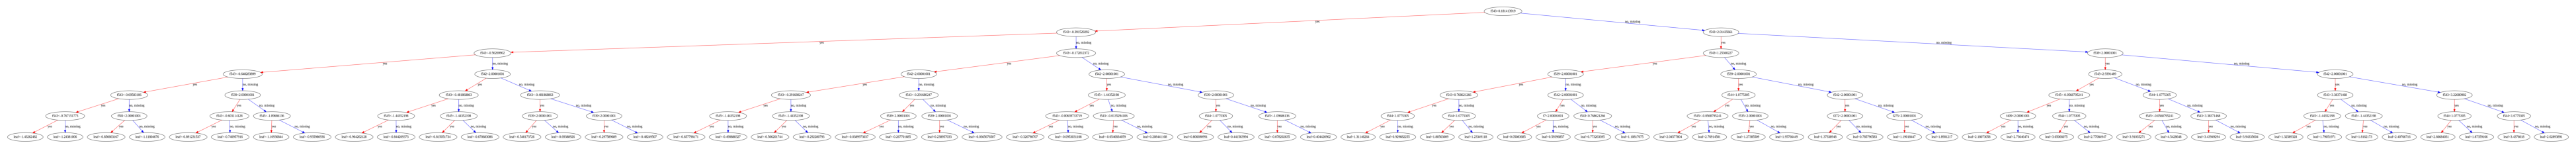

In [ ]:
booster = best_model.named_steps['xgb'].get_booster()

xgb.plot_tree(booster, num_trees=0)
plt.show()

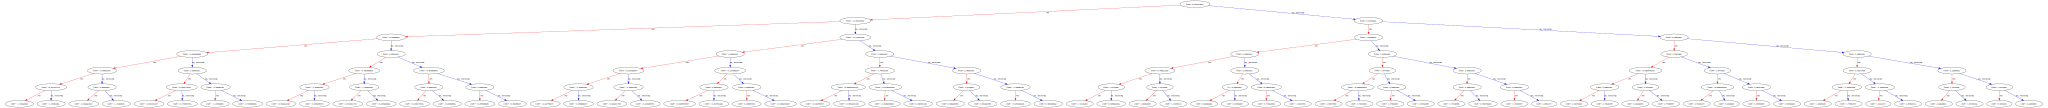

In [ ]:
xgb.to_graphviz(booster, num_trees=0)


### SHAP

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(best_model.named_steps['xgb'])

X_sample = X_test_prep[:100].toarray()
shap_values = explainer.shap_values(X_sample)

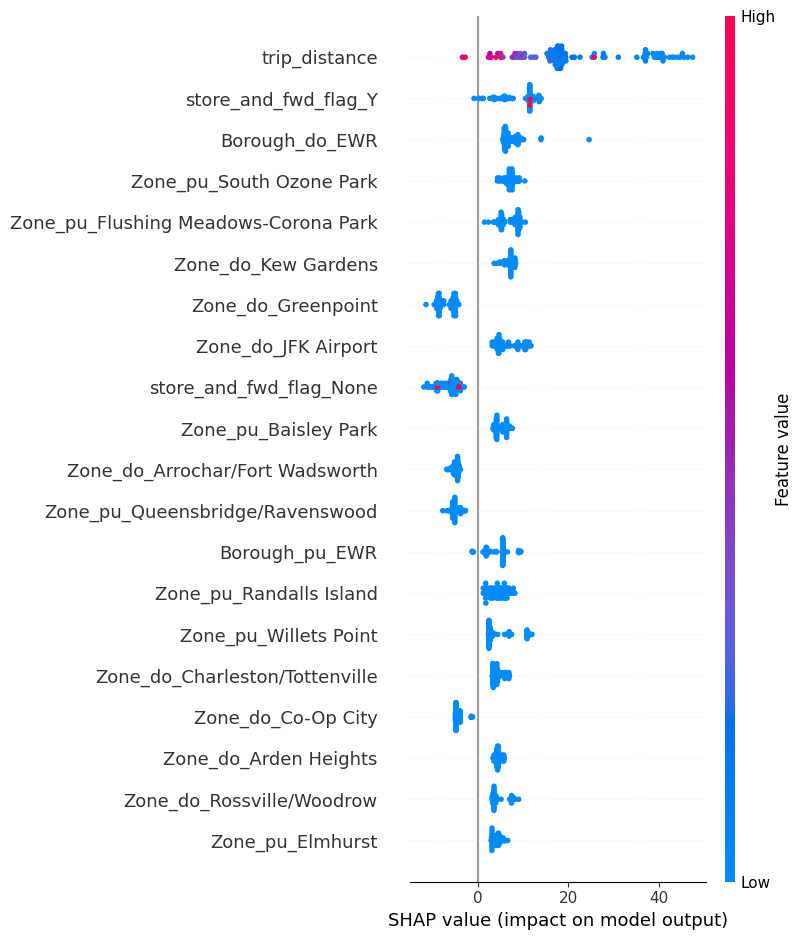

In [ ]:
shap.summary_plot(shap_values, X_sample, feature_names=final_feature_names)

In [ ]:
shap.initjs()

In [ ]:
i = 0  # index of the sample
shap.force_plot(
    explainer.expected_value,
    shap_values[i,:],
    X_sample[i,:]
)

### Cross Validation training

In [ ]:
import sklearn
sklearn.__version__

'1.5.0'

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [ ]:
cv_xgboost_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(cv_xgboost_model, X_train_prep, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: -3.377 (0.008)


In [ ]:
print(cv_xgboost_model.get_xgb_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None, 'predictor': 'gpu_predictor'}


# XGBOOST with Target Encoders

## GridSearch

In [4]:
! pip install category_encoders==2.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.5 MB/s eta 0:00:00


### OLD Model without Weather DATA

In [39]:
one_hot_features = ['store_and_fwd_flag', 'Borough_pu', 'service_zone_pu',
       'Borough_do', 'service_zone_do', 'time_of_day_pu']
categorical_features = ['Zone_pu', 'Zone_do']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu']
all_features = categorical_features + numerical_features + one_hot_features

target_col = 'fare_amount'
# target_col = 'trip_duration'

X = cleaned_df[all_features]
y = cleaned_df[target_col]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### NEW MODEL with Weather DATA

In [19]:
one_hot_features = ['Borough_pu', 'service_zone_pu',
       'Borough_do', 'service_zone_do', 'time_of_day_pu']
categorical_features = ['Zone_pu', 'Zone_do']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu',
                      'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']
all_features = categorical_features + numerical_features + one_hot_features

# target_col = 'fare_amount'
target_col = 'trip_duration'

X = cleaned_df[all_features]
y = cleaned_df[target_col]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Actual model Training

In [32]:
# for_one_hot_preprocessor = ColumnTransformer(
#     transformers=[
#         ('target_enc', ce.TargetEncoder(), categorical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_features),
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

xgb_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

target_encoder = ce.TargetEncoder(
    cols=categorical_features,
    smoothing=0.3,
    return_df=True
)

preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown='ignore'), one_hot_features),
    ("num_scaler", StandardScaler(), numerical_features)
], remainder='passthrough')

# 4) Assemble everything into a single Pipeline
model_pipeline = Pipeline([
    ("target_enc", target_encoder),
    ("col_transform", preprocessor),
    ("xgb", xgb_model)
])

In [33]:
param_grid = {
    "target_enc__smoothing": [0.3, 0.7],
    "xgb__max_depth": [3, 6],
    "xgb__n_estimators": [100, 200],
    "xgb__learning_rate": [0.1, 0.01],
    "xgb__reg_alpha": [0, 0.1, 0.6]
}

from sklearn.model_selection import KFold

# We'll do a 5-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [23]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:01:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:01:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use t

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('target_enc',
                                        TargetEncoder(cols=['Zone_pu',
                                                            'Zone_do'],
                                                      smoothing=0.3)),
                                       ('col_transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Borough_pu',
                                                                          'service_zone_pu',
                                                                          'Borough_do',
                                                                          'service_zone_do',
                                                                          'tim...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor='gpu_predictor', ...))]),
             n_jobs=-1,
             param_grid={'target_enc__smoothing': [0.3, 0.7],
                         'xgb__learning_rate': [0.1, 0.01],
                         'xgb__max_depth': [3, 6],
                         'xgb__n_estimators': [100, 200],
                         'xgb__reg_alpha': [0, 0.1, 0.6]},
             scoring='neg_mean_absolute_error', verbose=1)

In [24]:
best_model = grid_search.best_estimator_
dump(best_model, f'xgb_target_encoder_{target_col}.pkl')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:01:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


['xgb_target_encoder_trip_duration.pkl']

### Load previous model

In [52]:
best_model = load(f'xgb_model_{target_col}.v1.pkl')

In [62]:
best_model.named_steps['xgb'].max_depth

6

### Validation of training

In [38]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Statistics for trip_duration
Test MSE: 37.667
Test MAE: 3.646
Test RMSE: 6.137
Test R²: 0.817


In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:13:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Statistics for fare_amount
Test MSE: 18.738
Test MAE: 2.637
Test RMSE: 4.329
Test R²: 0.923


In [25]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for trip_duration
Test MSE: 29.589
Test MAE: 3.444
Test RMSE: 5.440
Test R²: 0.857


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for fare_amount
Test MSE: 10.109
Test MAE: 1.952
Test RMSE: 3.180
Test R²: 0.958


In [44]:
X_test.shape

(637639, 11)

# XGBOOST w Target Encodes + Bins for Weather

In [23]:
categorical_features = ['Zone_pu', 'Zone_do']
one_hot_features = ['store_and_fwd_flag', 'Borough_pu', 'service_zone_pu',
                    'Borough_do', 'service_zone_do', 'time_of_day_pu']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu',
                      'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']

all_features = categorical_features + numerical_features + one_hot_features

target_col = 'fare_amount'
# target_col = 'trip_duration'

X = cleaned_df[all_features]
y = cleaned_df[target_col]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Encoders

In [25]:
from sklearn.preprocessing import KBinsDiscretizer

In [26]:
gb_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

target_encoder = ce.TargetEncoder(
    cols=categorical_features,
    smoothing=0.3,
    return_df=True
)

snow_binner = KBinsDiscretizer(n_bins=3, encode="onehot", strategy="quantile")
wdir_binner = KBinsDiscretizer(n_bins=8, encode="onehot", strategy="uniform")


preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown='ignore'), one_hot_features),
    ("num_scaler", StandardScaler(), numerical_features),
    ("snow_bin", snow_binner, ['snow']),
    ("wdir_bin", wdir_binner, ['wdir'])
], remainder='passthrough')

xgb_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

# 4) Assemble everything into a single Pipeline
model_pipeline = Pipeline([
    ("target_enc", target_encoder),
    ("col_transform", preprocessor),
    ("xgb", xgb_model)
])

### Model Training

In [27]:
param_grid = {
    "target_enc__smoothing": [0.3, 0.7],
    "xgb__max_depth": [6, 8],
    "xgb__n_estimators": [150, 250],
    "xgb__learning_rate": [0.15, 0.25],
    "xgb__reg_alpha": [0, 0.2, 0.35]
}

from sklearn.model_selection import KFold

# We'll do a 5-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [28]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:22:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:22:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainde

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('target_enc',
                                        TargetEncoder(cols=['Zone_pu',
                                                            'Zone_do'],
                                                      smoothing=0.3)),
                                       ('col_transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['store_and_fwd_flag',
                                                                          'Borough_pu',
                                                                          'service_zone_pu',
                                                                          'Borough_do',
                                                                          '...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor='gpu_predictor', ...))]),
             n_jobs=-1,
             param_grid={'target_enc__smoothing': [0.3, 0.7],
                         'xgb__learning_rate': [0.15, 0.25],
                         'xgb__max_depth': [6, 8],
                         'xgb__n_estimators': [150, 250],
                         'xgb__reg_alpha': [0, 0.2, 0.35]},
             scoring='neg_mean_absolute_error', verbose=1)

In [29]:
best_model = grid_search.best_estimator_

In [30]:
dump(best_model, f'xgb_model_weather_bins_ohe_{target_col}.pkl')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:22:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


['xgb_model_weather_bins_ohe_fare_amount.pkl']

In [31]:
best_model.named_steps['xgb'].reg_alpha

0

### Load saved **model**

In [ ]:
best_model = load(f'xgb_model_{target_col}.v1.pkl')

### Validation steps

# OneHot Encoder for bins

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Statistics for trip_duration
Test MSE: 13.310
Test MAE: 2.316
Test RMSE: 3.648
Test R²: 0.872


In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for fare_amount
Test MSE: 2.858
Test MAE: 0.970
Test RMSE: 1.691
Test R²: 0.969


In [97]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for trip_duration
Test MSE: 24.619
Test MAE: 3.095
Test RMSE: 4.962
Test R²: 0.881


In [90]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for fare_amount
Test MSE: 8.589
Test MAE: 1.760
Test RMSE: 2.931
Test R²: 0.965


##### Ordinal encoder for bins

In [74]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for trip_duration
Test MSE: 26.326
Test MAE: 3.226
Test RMSE: 5.131
Test R²: 0.872


In [82]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Statistics for {target_col}")
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Statistics for fare_amount
Test MSE: 8.539
Test MAE: 1.759
Test RMSE: 2.922
Test R²: 0.965
